<a href="https://colab.research.google.com/github/ssktotoro/neuro/blob/tutorial_branch/GMWM_Prediction_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain tissue segmentation and An (almost) instant brain atlas segmentation**

In this notebook we demonstrate how to perform inference with pretrained MeshNet and UNet models.

## Gray Matter White Matter Segmentation

The models were pretrained with 13 Volumes from the Human Connectome Project and have DICE scores .898 (MeshNet_large), .881 (Unet), and .856 (MeshNet) on 3 held out volumes with 512 sampled subvolumes.  Notably the MeshNet models are 6-1.45x faster and 320-32x  smaller (.9mb vs. 9mb vs 289 mb).  With only a few more volumes of training the smallest MeshNet still outperforms UNet on the task as reported in https://arxiv.org/pdf/1612.00940.pdf.

## Almost Instant Brain Atlas Segmentation
We also demonstrate inference using the pretrained large MeshNet model mentioned in https://arxiv.org/pdf/1711.00457.pdf, which achieved ~.85 Macro DICE on for 103 classes.  

Authors: [Kevin Wang](https://github.com/ssktotoro/), [Alex Fedorov](https://github.com/Entodi/), [Sergey Kolesnikov](https://github.com/Scitator)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

## Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `\"Python 3\"` and `\"GPU\"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run all` and watch the tutorial.

## Setup Environment

In [ ]:
%%bash 
git clone https://github.com/ssktotoro/neuro.git -b tutorial_branch
pip install -r neuro/requirements/requirements.txt

## Setup imports

In [2]:
import torch
import nibabel as nib
from catalyst.metrics.functional._segmentation import dice
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
cd neuro

/content/neuro


In [4]:
from infer import Predictor
from training.model import MeshNet, UNet

## Download models

In [ ]:
%%bash 

download-gdrive 1pfVkepXXp0CfSMIsPVznwH0UEPytUUkN meshnet_gmwm_large_train.30_full.pth
download-gdrive 1XCbM57loIUs_tVJeMZaGazG_Id4jPZMy meshnet_gmwm_train.30_full.pth
download-gdrive 13dJY9i5xCd3IEBvOg9QsFCEhBbhvvJHZ unet_gmwm_train.30_full.pth
download-gdrive 1t0OiTL3cnzV4PdbL1LZm2JCz1kZNABB4 meshnet_hcp_train.30_full.pth

download-gdrive 1EBRKOwFXFNvInaCgCtdhNy9ZC0-8DO4L meshnet_gmwm_large_dropout_train.30_full.pth
download-gdrive 1hiDHb7Qr91QQVKTionQoZr9JUuzWHjGO meshnet_gmwm_dropout_train.30_full.pth

### Prepare Models for inference and download a sample T1 scan

We process non-overlapping 38x38x38 Subvolumes across the existing volume space with their corresponding labels + Randomly sampled 38x38x38 Subvolumes from a Normal Distribution accross volume space until the required number of subvolumes is reached.  Here we use 512 subvolumes for demonstration though more subvolumes can increase the DICE score.

In [26]:
volume_shape = [256, 256, 256]
subvolume_shape = [38, 38, 38]
n_subvolumes = 1024
n_classes = 3
atlas_classes = 104
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
meshnet_large_model = MeshNet(n_channels=1, n_classes=n_classes, large=True)
meshnet_large_model.load_state_dict(torch.load('meshnet_gmwm_large_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_large_model.to(device)
meshnet_large_predictor = Predictor(meshnet_large_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

meshnet_dropout_model = MeshNet(n_channels=1, n_classes=n_classes, large=False)
meshnet_dropout_model.load_state_dict(torch.load('meshnet_gmwm_dropout_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_dropout_model.to(device)
meshnet_dropout_predictor = Predictor(meshnet_dropout_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

meshnet_large_dropout_model = MeshNet(n_channels=1, n_classes=n_classes, large=True)
meshnet_large_dropout_model.load_state_dict(torch.load('meshnet_gmwm_large_dropout_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_large_dropout_model.to(device)
meshnet_large_dropout_predictor = Predictor(meshnet_large_dropout_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

meshnet_model = MeshNet(n_channels=1, n_classes=n_classes, large=False)
meshnet_model.load_state_dict(torch.load('meshnet_gmwm_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_model.to(device)
meshnet_predictor = Predictor(meshnet_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

meshnet_atlas_model = MeshNet(n_channels=1, n_classes=atlas_classes, large=True)
meshnet_atlas_model.load_state_dict(torch.load('meshnet_hcp_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_atlas_model.to(device)
meshnet_atlas_predictor = Predictor(meshnet_atlas_model, volume_shape, subvolume_shape, n_subvolumes, atlas_classes)

unet_model = UNet(n_channels=1, n_classes=n_classes)
unet_model.load_state_dict(torch.load('unet_gmwm_train.30_full.pth', map_location=device)['model_state_dict'])
unet_model.to(device)
unet_predictor = Predictor(unet_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

In [9]:
! wget -nc https://dl.dropbox.com/s/g1vn5p3grifro4d/T1w.nii.gz

--2021-05-11 18:41:15--  https://dl.dropbox.com/s/g1vn5p3grifro4d/T1w.nii.gz
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.1.15, 2620:100:6017:15::a27d:20f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/g1vn5p3grifro4d/T1w.nii.gz [following]
--2021-05-11 18:41:15--  https://dl.dropboxusercontent.com/s/g1vn5p3grifro4d/T1w.nii.gz
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22872802 (22M) [application/octet-stream]
Saving to: ‘T1w.nii.gz’

T1w.nii.gz          100%[===================>]  21.81M  85.3MB/s    in 0.3s    

2021-05-11 18:41:16 (85.3 MB/s) - ‘T1w.nii.gz’ saved [22872802/22872802]



In [10]:
img = nib.load('T1w.nii.gz')
img = img.get_fdata()

## Segment Sample Brains with timing

In [11]:
%time meshnet_large_predicted_segmentation = meshnet_large_predictor.predict('T1w.nii.gz')

CPU times: user 54.6 s, sys: 177 ms, total: 54.8 s
Wall time: 54.7 s


In [12]:
%time meshnet_predicted_segmentation = meshnet_predictor.predict('T1w.nii.gz')

CPU times: user 8.83 s, sys: 0 ns, total: 8.83 s
Wall time: 8.78 s


In [13]:
%time meshnet_large_dropout_predicted_segmentation = meshnet_large_dropout_predictor.predict('T1w.nii.gz')

CPU times: user 53.6 s, sys: 7.46 ms, total: 53.6 s
Wall time: 53.4 s


In [14]:
%time meshnet_dropout_predicted_segmentation = meshnet_dropout_predictor.predict('T1w.nii.gz')

CPU times: user 8.92 s, sys: 49.2 ms, total: 8.97 s
Wall time: 8.92 s


In [15]:
%time meshnet_atlas_predicted_segmentation = meshnet_atlas_predictor.predict('T1w.nii.gz')

CPU times: user 56.8 s, sys: 742 ms, total: 57.5 s
Wall time: 57.4 s


In [28]:
%time unet_predicted_segmentation = unet_predictor.predict('T1w.nii.gz')

CPU times: user 1min 17s, sys: 130 ms, total: 1min 17s
Wall time: 1min 17s


## Visualize Predictions

In [17]:
def show_slices(slices, raw=True):
    if raw:
        cmap = 'jet'
    else:
        cmap = 'nipy_spectral'
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap='nipy_spectral')

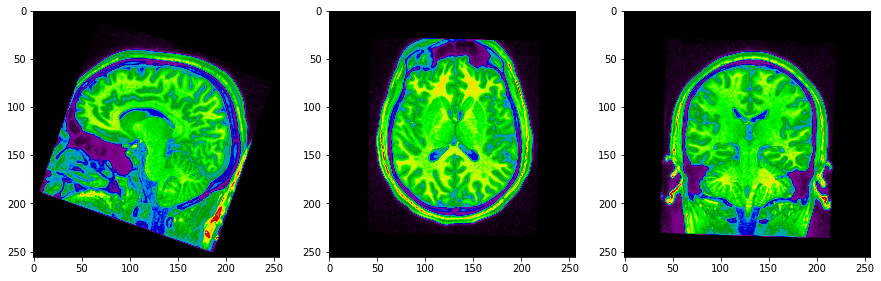

In [18]:
show_slices(
    [img[120, :,:][:, ::-1], 
     img[:, 120,:].T[::-1], 
     img[:, :, 120].T])

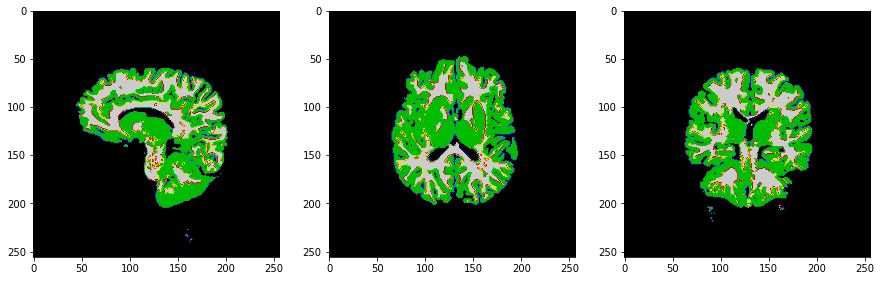

In [19]:
show_slices(
    [meshnet_large_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_large_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_large_predicted_segmentation[:, :, 120].cpu().T], raw=False)

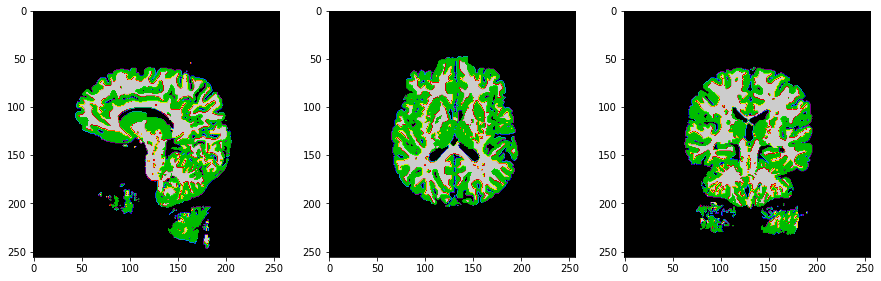

In [20]:
show_slices(
    [meshnet_large_dropout_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_large_dropout_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_large_dropout_predicted_segmentation[:, :, 120].cpu().T], raw=False)

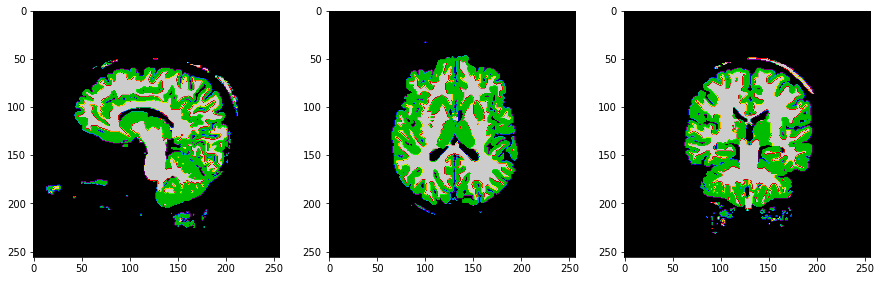

In [21]:
show_slices(
    [meshnet_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_predicted_segmentation[:, :, 120].cpu().T], raw=False)

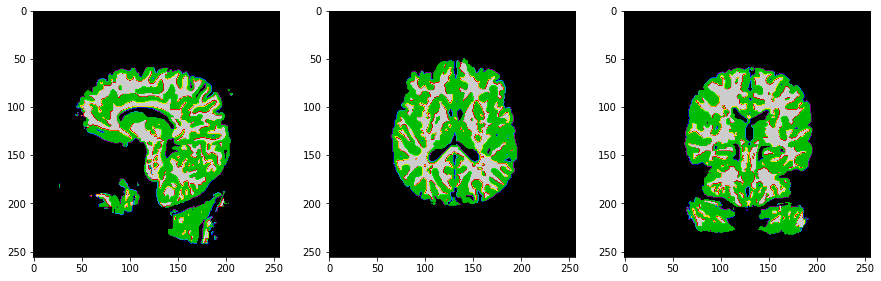

In [22]:
show_slices(
    [meshnet_dropout_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_dropout_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_dropout_predicted_segmentation[:, :, 120].cpu().T], raw=False)

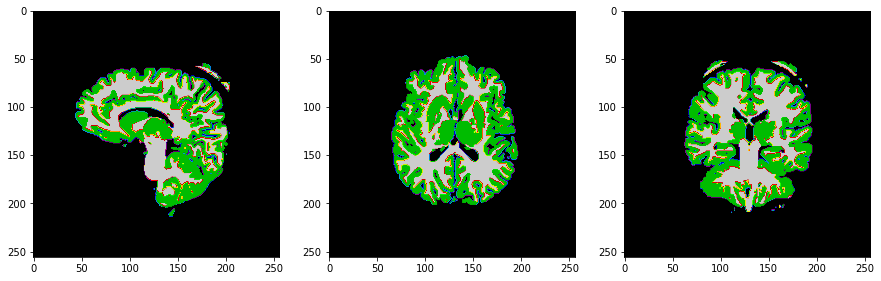

In [29]:
show_slices(
    [unet_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     unet_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     unet_predicted_segmentation[:, :, 120].cpu().T], raw=False)

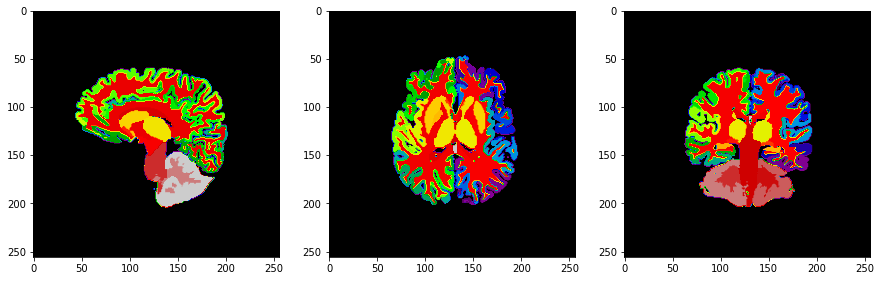

In [24]:
show_slices(
    [meshnet_atlas_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_atlas_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_atlas_predicted_segmentation[:, :, 120].cpu().T], raw=False)